In [2]:
import numpy as np
import random
import time
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib qt
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [30]:
class line_world(): #fixed goal position
    def __init__(self):
        self.min_position = -5
        self.max_position = 5
        self.max_speed = 0.1
        
    def reset(self):
        self.state = np.random.rand(1)*(self.max_position-self.min_position)+self.min_position
        self.goal_position = np.random.rand(1)*(self.max_position-self.min_position)+self.min_position
        return self.state, self.goal_position
    
    def compute_reward(self, old_state):
        if abs(self.state - self.goal_position) <= 0.05:
            reward = 100
            success = True
        else:
            reward = -1
            success = False
        return reward, success
    
    def step(self, action):
        action = action *self.max_speed
        old_state = self.state
        self.state = np.clip(self.state + action, self.min_position, self.max_position)
        
        reward, success = self.compute_reward(old_state)
        
        return self.state, reward, success
        
    def render(self,t,i):
        plt.figure(1)
        plt.clf()
        plt.plot((self.min_position, self.max_position), (0,0))
        plt.plot(self.state, 0, 'o', markersize=24)
        plt.plot(self.goal_position, 0, 'o', markersize=24)
        plt.savefig('plots/live/'+str(i)+'/live'+str(t)+'.png')

In [6]:
#REPLAY MEMORY

Transition = namedtuple('Transition', 
                        ('state', 'action', 'next_state', 'reward', 'goal'))

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        '''Saves a transition.'''
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [7]:
class critic_network(nn.Module):
    
    def __init__(self, input_dim, output_dim, units=4):
        super(critic_network, self).__init__()
        self.layer1 = nn.Linear(input_dim, units)
        self.bn1 = nn.BatchNorm1d(units)
        self.layer2 = nn.Linear(units, units)
        self.bn2 = nn.BatchNorm1d(units)
        self.layer3 = nn.Linear(units, output_dim)   
        self.output_dim = output_dim
        
    def forward(self, x, debug=False):
        x = F.relu(self.layer1(x))#F.relu(self.bn1(self.layer1(x)))
        x = F.relu(self.layer2(x))#F.relu(self.bn2(self.layer2(x)))
        x = self.layer3(x)
        return x

In [8]:
class actor_network(nn.Module):
    
    def __init__(self, input_dim, output_dim, units=4):
        super(actor_network, self).__init__()
        self.layer1 = nn.Linear(input_dim, units)
        self.bn1 = nn.BatchNorm1d(units)
        self.layer2 = nn.Linear(units, units)
        self.bn2 = nn.BatchNorm1d(units)
        self.layer3 = nn.Linear(units, output_dim)
        
        self.tanh = nn.Tanh()
        
        self.output_dim = output_dim
        
    def forward(self, x, debug=False):
        x = F.relu(self.layer1(x))#F.relu(self.bn1(self.layer1(x)))
        x = F.relu(self.layer2(x))#F.relu(self.bn2(self.layer2(x)))  
        x = self.layer3(x)
        return self.tanh(x)

In [9]:
def weights_update(tau, target_network, network):
    for target_param, param in zip(target_network.parameters(), network.parameters()):
        target_param.data.copy_(tau*param.data + target_param.data*(1.0 - tau))

In [10]:
def compute_reward(state, new_state, goal):
    if abs(new_state - goal) <= 0.05:
        reward = torch.tensor([100],dtype=torch.double)
    else:
        reward = torch.tensor([-1],dtype=torch.double)
    return reward

In [11]:
def plot_rewards(rewards):
    plt.figure(1)
    plt.clf()
    plt.title('Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards)
    plt.savefig('plots/rewards.png')
    
def plot_epoch_rewards(rewards):
    plt.figure(1)
    plt.clf()
    plt.title('Epoch Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards)
    plt.savefig('plots/epoch_rewards.png')
    
def plot_epoch_success(epoch_successes):
    plt.figure(1)
    plt.clf()
    plt.title('Epoch Success Rate')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    plt.plot(epoch_successes)
    plt.savefig('plots/epoch_success.png')
    
def plot_success(successes):
    plt.figure(2)
    plt.clf()
    plt.title('Success Rate')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    plt.plot(successes)
    plt.savefig('plots/successes.png')
    
def plot_qvalues(qvalues):
    plt.figure(3)
    plt.clf()
    plt.title('Q Values')
    plt.xlabel('Episode')
    plt.ylabel('Average Q Value')
    plt.plot(qvalues)
    plt.savefig('plots/qvalues.png')
    
def plot_losses(losses):
    plt.figure(4)
    plt.clf()
    plt.title('Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.plot(losses)
    plt.savefig('plots/losses.png')
    
def plot_Q(Q, goal=0):
    plt.figure(5)
    plt.clf()
    Q_values = np.zeros((21,21))
    for i,x in enumerate([-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-.5,0,.1,1,1.5,2,2.5,3,3.5,4,4.5,5]):
        for j,v in enumerate([-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]):
            Q_values[j,i] = Q.forward(torch.tensor([x,v,goal], dtype=torch.double, device=device))
    plt.imshow(Q_values, cmap ='bwr')
    x_positions = np.arange(0,21,5) # pixel count at label position
    x_labels = ['-1','-0.5','0','0.5','1'] # labels you want to see
    plt.yticks(x_positions, x_labels)
    plt.colorbar()
    plt.savefig('plots/Q/Q_map'+str(goal)+str(i_episode)+'.png')

def plot_mu(mu):
    plt.figure(6)
    plt.clf()
    mu_values = np.zeros((21,21))
    for i,x in enumerate([-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-.5,0,.1,1,1.5,2,2.5,3,3.5,4,4.5,5]):
        for j,goal in enumerate([-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-.5,0,.1,1,1.5,2,2.5,3,3.5,4,4.5,5]):
            mu_values[j,i] = mu.forward(torch.tensor([x,goal], dtype=torch.double, device=device))
    plt.imshow(mu_values, cmap='bwr',extent=[-5,5,5,-5])
    plt.xlabel('s_t')
    plt.ylabel('g')
    plt.colorbar()
    plt.savefig('plots/mu/mu_map'+str(i_episode)+'.png')


In [12]:
def optimize_model():
    if len(R) < BATCH_SIZE:
        return 0,0
   
    # sample a random minibatch of N transitions (si, ai, ri, si+1) from R
    transitions = R.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
        
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    next_state_batch = torch.cat(batch.next_state)
    reward_batch = torch.cat(batch.reward)
    goal_batch = torch.cat(batch.goal)
  
    with torch.no_grad():
        # set yi = ri + gamma*Q'(si+1,mu'(si+1))
        target_actions = target_mu(torch.cat((next_state_batch, goal_batch),1))
        y = reward_batch.view(BATCH_SIZE,1) + GAMMA*target_Q(torch.cat((next_state_batch, target_actions, goal_batch),1))
        
    
    # update critic by minimizing the MSE loss = 1/m sum (y - Q(si,ai))^2
    Q.train()
    Q_optimizer.zero_grad()    
    q = Q(torch.cat((state_batch, action_batch, goal_batch),1))
    loss = ((y-q)**2).mean()   
    loss.backward()
    Q_optimizer.step()
    
 
    # update the actor policy using the sampled policy gradient
    #gradient_mu = 1/N sum gradient(Q(si,mu(si)) wrt mu(si)) * gradient(mu(si), wrt mu.weights)
   
    mu.train()
    mu_optimizer.zero_grad()
    actions = mu(torch.cat((state_batch, goal_batch), 1))
    values = Q(torch.cat((state_batch, actions, goal_batch),1))
    mean_target_values = -values.mean()
    mean_target_values.backward()
    mu_optimizer.step()
    
    # update target networks
    #target_Q.weights = tau*target_Q.weights + (1-tau)*Q.weights
    #target_mu.weights = tau*target_mu + (1-tau)*mu.weights
    weights_update(TAU, target_Q, Q)
    weights_update(TAU, target_mu, mu)
    return mean_target_values, loss

In [13]:
BATCH_SIZE = 256
EPSILON = 1
EPSILON_DECAY = 0.999
EPSILON_MIN = 0.05
GAMMA = 0.999
TAU = 0.0000001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [34]:
def compute_epoch_avg():
    epoch_reward = 0
    success_rate = 0
    
    for i in range(100):
        # receive initial observation state s1
        episode_reward = 0
        state, goal = env.reset()
        goal = torch.tensor([goal], dtype=torch.double)
        state = torch.tensor([state], dtype=torch.double)
        t = 0
        while t < 600:
            t += 1
            #if i == 0:
            #env.render(t,i)
                
            # select action  
            #if i_episode % 10 != 0 or i_episode == 0:
            action = mu.forward(torch.cat((state, goal),1))

            # execute action at and observe reward rt and observe new state st+1

            next_state, reward, success = env.step(action.detach().numpy()[0,0])
            next_state = torch.tensor([next_state], dtype=torch.double, device=device)

            # move to the next state
            state = next_state

            episode_reward = episode_reward+ reward

            if success:
                success_rate += 1
                print('SUCCESS')
                print(goal)
                print(state)
                break
        epoch_reward += episode_reward

    return epoch_reward/100, success_rate/100
    

In [35]:
def pick_new_goal(R_episode, strategy = 'final'):
    
    if strategy == 'final':
        new_goal = episode_R.memory[episode_R.position-1].state
        return new_goal
    
    elif strategy == 'future':
        new_goal = random.sample(episode_R.memory[:], 1)[0].state
        return new_goal
        
    elif strategy == 'maximize':
            
        states = torch.tensor([x.state for x in episode_R.memory[:]], dtype=torch.double)
        next_states = torch.tensor([x.next_state for x in episode_R.memory[:]], dtype=torch.double)
        actions = torch.tensor([x.action for x in episode_R.memory[:]], dtype=torch.double)
        possible_goals = [x.state for x in episode_R.memory[:]]#random.sample(episode_R.memory[:], 5)]
        errors = []
        
        # compute bellman error
        with torch.no_grad():
            for goal in possible_goals:
                goal_tensor = torch.tensor([goal]*len(states))
                rewards = abs(states - goal_tensor)
                rewards[rewards>0.05] = -1
                rewards[rewards<=0.05] = 100
               
                 # set yi = ri + gamma*Q'(si+1,mu'(si+1))
                target_actions = target_mu(torch.cat((next_states.unsqueeze(1), goal_tensor.unsqueeze(1)),1))
                y = rewards + GAMMA*target_Q(torch.cat((next_states.unsqueeze(1), target_actions, goal_tensor.unsqueeze(1)),1))

                q = Q(torch.cat((states.unsqueeze(1), actions.unsqueeze(1), goal_tensor.unsqueeze(1)),1))

                error = ((y-q)**2).mean().detach().item()
                errors.append(error)
            
            # select maximal error
            return possible_goals[np.argmax(errors)]
        

SUCCESS
tensor([[-0.5163]], dtype=torch.float64)
tensor([[-0.4834]], dtype=torch.float64)
SUCCESS
tensor([[-0.9857]], dtype=torch.float64)
tensor([[-0.9506]], dtype=torch.float64)
SUCCESS
tensor([[-1.3208]], dtype=torch.float64)
tensor([[-1.2785]], dtype=torch.float64)
SUCCESS
tensor([[-0.1503]], dtype=torch.float64)
tensor([[-0.1177]], dtype=torch.float64)
SUCCESS
tensor([[0.5465]], dtype=torch.float64)
tensor([[0.5811]], dtype=torch.float64)
SUCCESS
tensor([[2.2557]], dtype=torch.float64)
tensor([[2.2942]], dtype=torch.float64)
SUCCESS
tensor([[-1.0477]], dtype=torch.float64)
tensor([[-1.0054]], dtype=torch.float64)
SUCCESS
tensor([[-1.7767]], dtype=torch.float64)
tensor([[-1.7286]], dtype=torch.float64)
SUCCESS
tensor([[2.3481]], dtype=torch.float64)
tensor([[2.3824]], dtype=torch.float64)
SUCCESS
tensor([[2.2394]], dtype=torch.float64)
tensor([[2.2653]], dtype=torch.float64)
SUCCESS
tensor([[0.9288]], dtype=torch.float64)
tensor([[0.9761]], dtype=torch.float64)
SUCCESS
tensor([[0.2

FileNotFoundError: [Errno 2] No such file or directory: 'plots/live/3/live1.png'

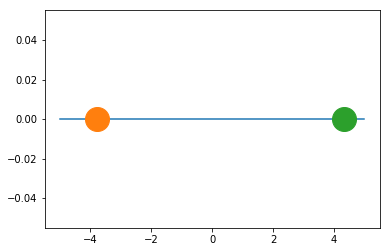

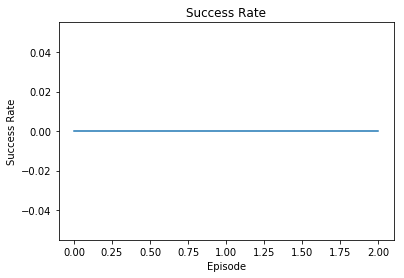

In [36]:
#WITH HINDSIGHT EXPERIENCE REPLAY

np.random.seed(0)
torch.manual_seed(0)

epoch_rewards = []
epoch_successes = []
rewards = []
successes = []
success_rate = 0
losses = []
qvalues = []

# randomly initialize critic network Q and actor mu
Q = critic_network(input_dim=3, output_dim=1).double().to(device)
mu = actor_network(input_dim=2, output_dim=1).double().to(device)

# create optimizers
Q_optimizer = optim.Adam(Q.parameters(), lr=0.0001)
mu_optimizer = optim.Adam(mu.parameters(), lr=0.0001)

# initialize target critic network Q' and target actor network mu' with same weights as Q and mu
target_Q = critic_network(input_dim=3, output_dim=1).double().to(device)
weights_update(1, target_Q, Q)
for p in target_Q.parameters():
        p.requires_grad = False

target_mu = actor_network(input_dim=2, output_dim=1).double().to(device)
weights_update(1, target_mu, mu)
for p in target_mu.parameters():
        p.requires_grad = False
        
# initialize replay buffer R
R = ReplayMemory(1000000) # size of replay buffer is 10^6


env = line_world() # set environment here
for i_episode in range(3000):
    episode_reward = 0
    episode_qval = 0
    episode_loss = 0
    episode_R = ReplayMemory(500)    
    
    # receive initial observation state s1
    state, goal = env.reset()
    state = torch.tensor([state], dtype=torch.double)
    goal = torch.tensor([goal], dtype=torch.double)
    t = 0
    while t < 500:
        t += 1
        
        env.render(t, i_episode)
        
        # select action  
        #if i_episode % 10 != 0 or i_episode == 0:
        action = mu.forward(torch.cat((state, goal),1))
        #if i_episode % 10 != 0 and i_episode != 0: # test policy with  no noise every tenth epoch
        if np.random.rand(1) < (EPSILON):
            #if np.random.rand(1) < (1-t/100):
            action = torch.tensor([np.random.rand(1)*2-1], dtype=torch.double)
            #action += 2*torch.tensor([np.random.randn(1)], dtype=torch.double)
        action = torch.clamp(action, -1, 1)
        
        # execute action at and observe reward rt and observe new state st+1
    
        next_state, reward, success = env.step(action.detach().numpy()[0,0])
        reward = torch.tensor([[reward]], dtype=torch.double, device=device)
        action = torch.tensor([[action]], device=device)
        next_state = torch.tensor([next_state], dtype=torch.double, device=device)
        
        # store transition (st, at, st+1, rt) in R
        R.push(state, action, next_state, reward, goal)
        episode_R.push(state, action, next_state, reward, goal)
            
        # move to the next state
        state = next_state
        
        #if i_episode % 10 != 0:
        qval, loss = optimize_model()
        episode_qval += qval
        episode_loss += loss
        
        episode_reward = episode_reward+ reward
        
        
        if success:
            success_rate += 1
            print('SUCCESS')
            print(state)
            print(goal)
            break
            
    new_goal = pick_new_goal(episode_R, strategy='future') 
    for i in range(episode_R.position):
        state = episode_R.memory[i].state
        action = episode_R.memory[i].action
        next_state = episode_R.memory[i].next_state
        reward = compute_reward(state, next_state, new_goal)        
        reward = reward.unsqueeze(0)
        R.push(state, action, next_state, reward, new_goal)
            
   
    if EPSILON > EPSILON_MIN:
        EPSILON *= EPSILON_DECAY
    # plot rewards
    if i_episode % 5 == 0:
        epoch_avg_reward, epoch_success = compute_epoch_avg()
        epoch_rewards.append(epoch_avg_reward)
        epoch_successes.append(epoch_success)
        plot_epoch_rewards(epoch_rewards)
        plot_epoch_success(epoch_successes)
    
    successes.append(success_rate/(i_episode+1))
    rewards.append(episode_reward/(i_episode+1))
    qvalues.append(episode_qval)
    losses.append(episode_loss)
    plot_success(successes)
    plot_rewards(rewards)
    #plot_qvalues(qvalues)
    #plot_losses(losses)
    #plot_Q(Q, goal=0)
    #plot_mu(mu)
    #plot_Q(Q, goal=-2)
    #plot_Q(Q, goal=2)
        

SUCCESS
tensor([[-0.3898]], dtype=torch.float64)
tensor([[-0.3864]], dtype=torch.float64)
SUCCESS
tensor([[4.8722]], dtype=torch.float64)
tensor([[4.8640]], dtype=torch.float64)
SUCCESS
tensor([[3.9051]], dtype=torch.float64)
tensor([[3.8641]], dtype=torch.float64)
SUCCESS
tensor([[4.6596]], dtype=torch.float64)
tensor([[4.6614]], dtype=torch.float64)
SUCCESS
tensor([[3.0095]], dtype=torch.float64)
tensor([[2.9984]], dtype=torch.float64)


FileNotFoundError: [Errno 2] No such file or directory: 'plots/live/5/live1.png'

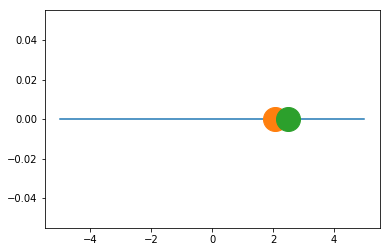

In [32]:
env = line_world() # set environment here
compute_epoch_avg()

In [211]:
pickle.dump(epoch_rewards, open('plots/epoch_rewards.p','wb'))
pickle.dump(epoch_successes, open('plots/epoch_successes.p','wb'))
pickle.dump(successes, open('plots/successes.p','wb'))

In [214]:
final_successes = pickle.load(open('plots/Final GOOD/epoch_successes.p','rb'))
future_successes = pickle.load(open('plots/future GOOD/epoch_successes.p','rb'))
no_successes = pickle.load(open('plots/no HER/epoch_successes.p','rb'))


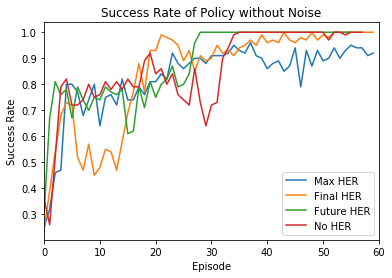

In [222]:
plt.plot(epoch_successes[0:60])
plt.plot(final_successes[0:60])
plt.plot(future_successes[0:60])
plt.plot(no_successes[0:60])
plt.xlim([0,60])
plt.xlabel('Episode')
plt.ylabel('Success Rate')
plt.title('Success Rate of Policy without Noise')
plt.legend(['Max HER', 'Final HER', 'Future HER', 'No HER'])

In [6]:
final_rewards = pickle.load(open('plots1d/Final GOOD/epoch_rewards.p','rb'))
future_rewards = pickle.load(open('plots1d/future GOOD/epoch_rewards.p','rb'))
no_rewards = pickle.load(open('plots1d/no HER/epoch_rewards.p','rb'))


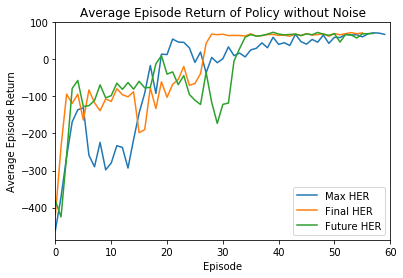

In [7]:
#plt.plot(epoch_rewards[0:60])
plt.plot(final_rewards[0:60])
plt.plot(future_rewards[0:60])
plt.plot(no_rewards[0:60])
plt.xlim([0,60])
plt.xlabel('Episode')
plt.ylabel('Average Episode Return')
plt.title('Average Episode Return of Policy without Noise')
plt.legend(['Max HER', 'Final HER', 'Future HER', 'No HER'])